# Email Spam Detection
### Dataset

In [1]:

import numpy as np
import pandas as pd

# data from https://www.kaggle.com/datasets/rockinjas123/spam-ham-emails
data = pd.read_csv('emails.csv')

data

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
...,...,...
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0


### Data Pre-Processing

In [2]:
print(f"Rows Before Pre-Pocessing: {len(data.index)}")

# drops duplicate rows. no need to have too many rows of the same values
data.drop_duplicates(inplace=True)

# since there are only 2 columns if any of them are null then those rows dont serve any functions
data.dropna(axis = 'index')

print(f"Rows After Pre-Pocessing: {len(data.index)}")

Rows Before Pre-Pocessing: 5728
Rows After Pre-Pocessing: 5695


In [3]:
from sklearn.model_selection import train_test_split

x = data.text.values
y = data.spam.values
xTrain, xTest, yTrain, yTest = train_test_split(x, y, train_size = 0.8, stratify = y)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()

# converting word to numbers via counting word frequencies: eg. "i hate spam. spam is bad" -> i = 1, hate = 1, spam = 2, is = 1, bad = 1
xTrain_cv = cv.fit_transform(xTrain)
xTest_cv = cv.transform(xTest)

##### Correlation

In [5]:

cvDf = pd.DataFrame(xTrain_cv.todense(), columns=cv.get_feature_names_out())
cvDf['spam@unique'] = yTrain
correlation = cvDf.corrwith(cvDf['spam@unique'])
correlation

00            -0.044479
000            0.095617
0000           0.123365
000000         0.026358
00000000      -0.013604
                 ...   
zzmacmac      -0.008329
zzn            0.026358
zzncacst      -0.008329
zzzz           0.042336
spam@unique    1.000000
Length: 33471, dtype: float64

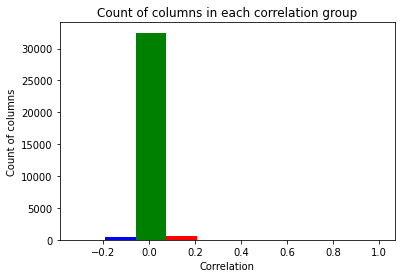

In [6]:
import matplotlib.pyplot as plt

N, bins, patches  = plt.hist(correlation)


patches[1].set_facecolor('blue')
patches[2].set_facecolor('green')
patches[3].set_facecolor('red')
# rest are default colors

plt.xlabel('Correlation')
plt.ylabel('Count of columns')
plt.title('Count of columns in each correlation group')

plt.show()

Since all of the word frequencies(x-variables) have almost no correlation with whether the email being spam or not (y), it can be concluded that the x-variables are not independent among each other. The x-variables are most likely dependant among each other.

##### Scaling

In [7]:
from sklearn.preprocessing import MaxAbsScaler

mas = MaxAbsScaler()
mas.fit(xTrain_cv)
xTrainScaled = mas.transform(xTrain_cv)
xTestScaled = mas.transform(xTest_cv)
# All x variables are scaled to be 0 to 1

### Modelling Data

In [8]:
def modelData(model, scaled=True):
  x = xTrainScaled if scaled else xTrain_cv
  y = yTrain
  model.fit(x,y)
  return model

In [9]:
from sklearn.metrics import precision_score, f1_score, recall_score, roc_curve, roc_auc_score, ConfusionMatrixDisplay


def display_score(trained_model, scaled = True, probability = True):
  x = xTestScaled if scaled else xTest_cv
  y = yTest
  y_pred = trained_model.predict(x)
  name = str(type(trained_model).__name__)
  name += " <Scaled Data>" if scaled else ""

  acc = trained_model.score(x, y)
  prec = precision_score(y, y_pred)
  f1scre = f1_score(y, y_pred)
  recal = recall_score(y, y_pred)
  
  print(f"Accuracy: {acc}\nPrecision: {prec}\nF1 Score: {f1scre}\nRecall Score: {recal}")

  fpr, tpr = None, None
  if probability:
    y_score = trained_model.predict_proba(x)
    y_score = y_score[:, 1]
    rocAuc = roc_auc_score(y, y_score)
    fpr, tpr, _ = roc_curve(y, y_score)
    print(f"ROC AUC score: {rocAuc}")
  print()
  mat = ConfusionMatrixDisplay.from_predictions( y, y_pred)
  plt.title(f"Confusion matrix for {name}")
  plt.show()
  print()
  return {"name":name , "acc": acc, "prec":prec, "f1scre":f1scre, "recal":recal, "fpr":fpr, "tpr":tpr, "mat": mat}

In [10]:
customTests = [
  "Hello sir! When is the deadline for CSE422 project report submission?",
  "Dear Students, The University is happy to offer a student transport service and wishes to keep the price as low as feasible while covering the cost of the service. You all know that the price of fuel has increased significantly: the price of diesel has increased by 42.5% (Previous price- Tk.80, New price Tk.114).Bus fares have already been raised across the country. Despite the increase in the fuel price, the University will keep the student transport fares unchanged for the remainder of the current semester. There will be a need, however, to increase the fare to Tk. 90 from Tk.70 with effect from the start of the fall semester. The University hopes that you will understand the pressures that have led to this change. Best regards, Office of the Registrar",
  "Click here to get free discord nitro"
  ]
customTests_cv = cv.transform(customTests)
customTestsScaled = mas.transform(customTests_cv)

def getCustomTestResults(model, scaled=True):

  results = model.predict(customTestsScaled if scaled else customTests_cv)
  assert len(results) == len(customTests), f"length of results, {len(results)} and tests, {len(customTests)} are unequal"
  print("Custom string results:")
  for i in range(len(results)):
    spam = "spam" if results[i] == 1 else "ok"
    if len(customTests[i]) > 80:
      print(f"{spam}  -->  \"{customTests[i][0:35]} ... {customTests[i][-35:]}\"")
    else:
      print(f"{spam}  -->  \"{customTests[i]}\"")

##### Multinomial Naive Bayes

Accuracy: 0.9780509218612818
Precision: 1.0
F1 Score: 0.9521988527724665
Recall Score: 0.9087591240875912
ROC AUC score: 0.9949917724990506



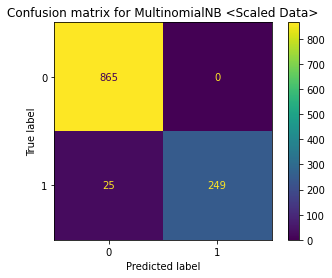


Custom string results:
ok  -->  "Hello sir! When is the deadline for CSE422 project report submission?"
ok  -->  "Dear Students, The University is ha ... st regards, Office of the Registrar"
ok  -->  "Click here to get free discord nitro"


In [11]:
from sklearn.naive_bayes import MultinomialNB as MNB

# scaled
mnbModelScaled = modelData(MNB())

mnbS = display_score(mnbModelScaled)

getCustomTestResults(mnbModelScaled)

Accuracy: 0.9885864793678666
Precision: 0.9851301115241635
F1 Score: 0.9760589318600369
Recall Score: 0.9671532846715328
ROC AUC score: 0.9965275726762582



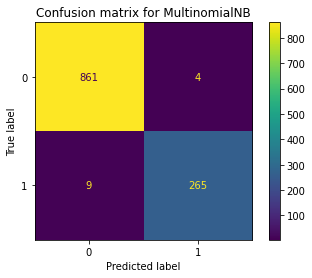


Custom string results:
ok  -->  "Hello sir! When is the deadline for CSE422 project report submission?"
ok  -->  "Dear Students, The University is ha ... st regards, Office of the Registrar"
spam  -->  "Click here to get free discord nitro"


In [12]:
mnbModel = modelData(MNB(), False)

mnb = display_score(mnbModel, False)

getCustomTestResults(mnbModel, False)

##### Support Vector Classifier

Accuracy: 0.9648814749780509
Precision: 0.9717741935483871
F1 Score: 0.9233716475095787
Recall Score: 0.8795620437956204
ROC AUC score: 0.9945107801358593



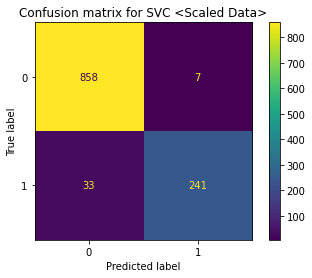


Custom string results:
ok  -->  "Hello sir! When is the deadline for CSE422 project report submission?"
ok  -->  "Dear Students, The University is ha ... st regards, Office of the Registrar"
ok  -->  "Click here to get free discord nitro"


In [13]:
from sklearn.svm import SVC

# scaled
svcModelScaled = modelData( SVC(kernel="linear", probability = True) )

svcS = display_score(svcModelScaled, probability= True )

getCustomTestResults(svcModelScaled )

Accuracy: 0.9877085162423178
Precision: 0.9814814814814815
F1 Score: 0.9742647058823529
Recall Score: 0.9671532846715328
ROC AUC score: 0.9964220918948568



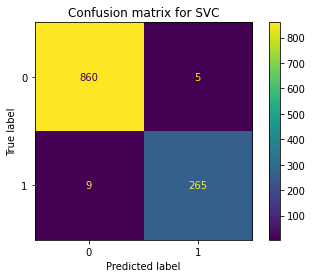


Custom string results:
ok  -->  "Hello sir! When is the deadline for CSE422 project report submission?"
ok  -->  "Dear Students, The University is ha ... st regards, Office of the Registrar"
spam  -->  "Click here to get free discord nitro"


In [14]:
svcModel = modelData( SVC(kernel="linear", probability=True) , False)

svc = display_score(svcModel, False, True)

getCustomTestResults(svcModel, False)

##### Random Forest Classifier

Accuracy: 0.9675153643546971
Precision: 1.0
F1 Score: 0.9275929549902152
Recall Score: 0.864963503649635
ROC AUC score: 0.9982785536475255



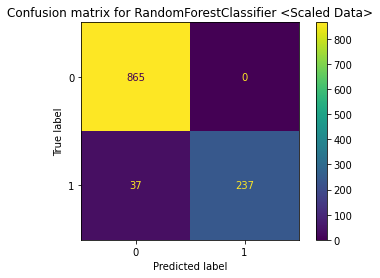


Custom string results:
ok  -->  "Hello sir! When is the deadline for CSE422 project report submission?"
ok  -->  "Dear Students, The University is ha ... st regards, Office of the Registrar"
ok  -->  "Click here to get free discord nitro"


In [15]:
from sklearn.ensemble import RandomForestClassifier as RFC

# scaled
rfcModelScaled = modelData(RFC(n_estimators=50))

rfcS = display_score(rfcModelScaled)

getCustomTestResults(rfcModelScaled)

Accuracy: 0.9648814749780509
Precision: 1.0
F1 Score: 0.9212598425196851
Recall Score: 0.8540145985401459
ROC AUC score: 0.9989304248765876



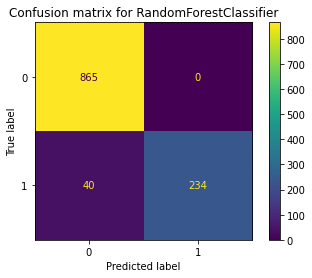


Custom string results:
ok  -->  "Hello sir! When is the deadline for CSE422 project report submission?"
ok  -->  "Dear Students, The University is ha ... st regards, Office of the Registrar"
spam  -->  "Click here to get free discord nitro"


In [16]:
rfcModel = modelData(RFC(n_estimators=50), False)

rfc = display_score(rfcModel, False)

getCustomTestResults(rfcModel, False)

### Results

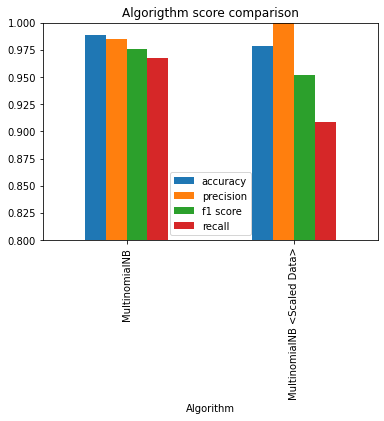

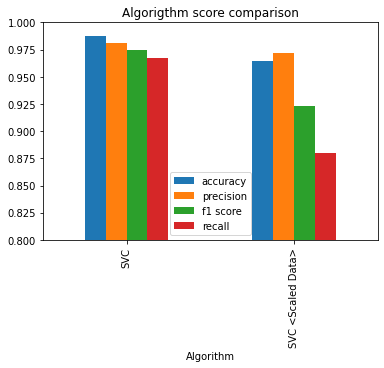

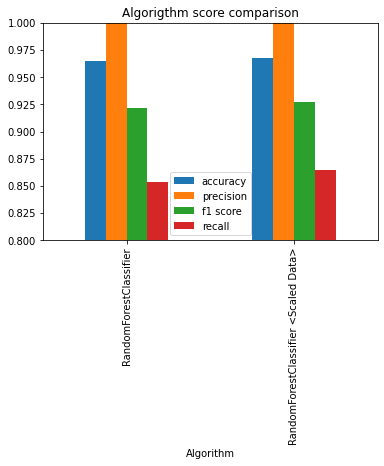

In [17]:
# create data
def algoResArray(algo):
  return [ algo["name"], algo["acc"], algo["prec"], algo["f1scre"], algo["recal"] ]

def displayScore(algo1, algo2):
  df = pd.DataFrame([
    algoResArray(algo1), 
    algoResArray(algo2),
  ],

  columns=[ 'Algorithm', "accuracy", "precision", "f1 score", "recall" ])

  df.plot(
    x='Algorithm',
    kind='bar',
    stacked=False,
    title='Algorigthm score comparison',
    ylim=(0.8,1)
  )

displayScore(mnb, mnbS)
displayScore(svc, svcS)
displayScore(rfc, rfcS)

##### ROC-Curve

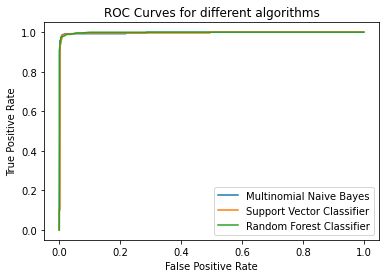

In [18]:
plt.plot(mnb["fpr"], mnb["tpr"], label= "Multinomial Naive Bayes")

plt.plot(svc["fpr"], svc["tpr"], label= "Support Vector Classifier")

plt.plot(rfc["fpr"], rfc["tpr"], label= "Random Forest Classifier")

plt.title('ROC Curves for different algorithms')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()